In [1]:
import math
import json
import warnings
import numpy as np
import pandas as pd
import csv
import copy
import matplotlib.pyplot as plt
import scipy as sp
import itertools
import random
import time

import glob
import os, sys

from collections import OrderedDict
from IPython.display import display, HTML

from cryptorandom.cryptorandom import SHA256, int_from_hash
from cryptorandom.sample import sample_by_index

from shangrla.core.Audit import Audit, Assertion, Assorter, Contest, CVR, Stratum
from shangrla.core.NonnegMean import NonnegMean
from shangrla.formats.Dominion import Dominion

from utils import Bets, Allocations, Weights, mart, lower_confidence_bound, global_lower_bound,\
    intersection_mart, plot_marts_eta, construct_exhaustive_eta_grid, selector,\
    construct_eta_grid_plurcomp, construct_eta_bands, simulate_plurcomp, PGD, convex_uits,\
    banded_uits, brute_force_uits, generate_oneaudit_population

### SF CVR download info
Download the SF CVRs from https://sfelections.org/results/20241105w/detail.html 

Under the 'Final Report' tab click "Cast Vote Record (Raw data) - JSON" to download a zip file with all the CVRs. You will edit the file path for 'cvr_file' below based on where you put the CVR folder once downloaded.

In [148]:
audit = Audit.from_dict({
         'seed':           12345678901234567890,
         'sim_seed':       314159265,
         'cvr_file':       '../../sf-cvrs-2024/CvrExport_*.json', # Edit with your file path
         'manifest_file':  '../../sf-cvrs-2024/BallotTypeManifest.json',
         'sample_file':    '...', # EDIT
         'mvr_file':       '...', # EDIT
         'log_file':       '...', # EDIT
         'quantile':       0.8,
         'error_rate_1':   0.001,
         'error_rate_2':   0.0,
         'reps':           200,
         'strata':         {'stratum_1': {'max_cards':   1603908, 
                                          'use_style':   True,
                                          'replacement': False
                                         }
                           }
        })

In [149]:
## Read the CVRs
# Group = 1 is precinct, 2 is vote-by-mail
# tally_pool will give precinct, pool will indicate if has CVRs
cvr_list = []
for _fname in glob.glob(audit.cvr_file):
    cvr_list.extend(Dominion.read_cvrs(_fname, use_current=True, enforce_rules=True, include_groups=[1,2],
                                      pool_groups=[1]))

In [150]:
# Tabulate votes for each contest
vote_tabulation = CVR.tabulate_votes(cvr_list)

In [151]:
# Mayor contest is contest ID 18
print(vote_tabulation['18']) # votes for candidates
print(sum(vote_tabulation['18'].values())) # total votes

# President contest is contest ID 1
# print(vote_tabulation['1']) # votes for candidates
# print(sum(vote_tabulation['1'].values())) # total votes

defaultdict(<class 'int'>, {'55': 204829, '57': 257051, '62': 243460, '65': 31455, '64': 117898, '61': 192214, '54': 43067, '56': 53638, '58': 54318, '66': 68829, '59': 49611, '60': 34424, '63': 51138, '173': 29, '176': 9, '175': 10})
1401980


In [153]:
# count number of CVRs with mayoral contest
mayor = 0
for cvr in cvr_list:
    if cvr.has_contest('18'):
        mayor = mayor + 1

print(mayor)

410105


In [154]:
# Mayoral contest
contest_dict = {
               '18':{
                   'name': 'MAYOR',
                   'risk_limit':       0.05,
                   'cards':            410105,
                   'choice_function':  Contest.SOCIAL_CHOICE_FUNCTION.PLURALITY,
                   'n_winners':        1,
                   'candidates':       ['54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '173', '175', '176'],
                   'winner':           ['57'],
                   'assertion_file':   None,
                   'audit_type':       Audit.AUDIT_TYPE.ONEAUDIT,
                   'test':             NonnegMean.alpha_mart,
                   'estim':            NonnegMean.shrink_trunc,
                   'test_kwargs':      {'d': 100, 'f': 0}
                  }
               }

# contest_dict = {
#                '1':{
#                    'name': 'PRESIDENT AND VICE PRESIDENT',
#                    'risk_limit':       0.05,
#                    'cards':            412121,
#                    'choice_function':  Contest.SOCIAL_CHOICE_FUNCTION.PLURALITY,
#                    'n_winners':        1,
#                    'candidates':       ['5', '2', '4', '6', '3', '1', '174'],
#                    'winner':           ['5'],
#                    'assertion_file':   None,
#                    'audit_type':       Audit.AUDIT_TYPE.ONEAUDIT,
#                    'test':             NonnegMean.alpha_mart,
#                    'estim':            NonnegMean.shrink_trunc,
#                    'test_kwargs':      {'d': 100, 'f': 0}
#                   }
#                }

contests = Contest.from_dict_of_dicts(contest_dict)

In [155]:
# construct the dict of dicts of assertions for each contest
Assertion.make_all_assertions(contests)

True

In [156]:
# check that the CVR IDs are unique
unique_ids = len(set(c.id for c in cvr_list))
print(f'cvrs: {len(cvr_list)} unique IDs: {unique_ids}')
assert unique_ids == len(cvr_list), 'CVR IDs are not unique'

cvrs: 1603908 unique IDs: 1603908


In [157]:
# ensure every CVR in each tally_pool has the same value of `pool`
cvr_list = CVR.check_tally_pools(cvr_list)
len(cvr_list)

1603908

In [158]:
# find the set of tally_pools for which pool==True
pools = set(c.tally_pool for c in cvr_list if c.pool)
len(pools)

4223

In [159]:
# make dict of all contest IDs mentioned in each tally_pool of CVRs for which pool==True
tally_pools = CVR.pool_contests(cvr_list)

# ensure every CVR in each tally_pool for which pool==True has every contest in that tally_pool
CVR.add_pool_contests(cvr_list, tally_pools)

True

In [160]:
# set pooled assorter means
for con in contests.values():
    for a in con.assertions.values():
        a.assorter.set_tally_pool_means(cvr_list=cvr_list, tally_pools=tally_pools)

### ONEAudit Simulations

In [163]:
# get vector of batch sizes, reported assorter means and proportion invalids
batch_sizes = []
A_c = []
invalid = []
tally_pool_val = []
for con in contests.values():
    for a in con.assertions.values():
        if a.loser == '62': # London Breed loser
            tally_pool_values = a.assorter.count_tally_pool_vals(cvr_list=cvr_list, tally_pools=tally_pools)
            for t in tally_pool_values:
                if tally_pool_values[t]['n'] != 0:
                    tally_pool_val.append(t)
                    batch_sizes.append(tally_pool_values[t]['n'])
                    invalid.append(tally_pool_values[t][0.5]/tally_pool_values[t]['n'])
                    A_c.append((0.5*tally_pool_values[t][0.5] + tally_pool_values[t][1])/tally_pool_values[t]['n'])

In [165]:
# Combine into DataFrame
# sf_df = pd.DataFrame({
#     'batch_sizes': batch_sizes,
#     'A_c': A_c,
#     'invalid': invalid
# })

# # Save to CSV
# sf_df.to_csv("sf_batches_df.csv", index=False)

In [166]:
# Generate ONEAudit population
assorter_pop_unscaled = generate_oneaudit_population(
            batch_sizes = batch_sizes,
            A_c = A_c,
            invalid = invalid
        )

In [167]:
eta_0_unscaled = 1/2 # global null mean
u = 1 # upper bound for plurality assorters

realized_A_c_global = np.dot(batch_sizes / np.sum(batch_sizes), A_c) # the actual global mean based on the batch sizes and means
v_global = 2 * realized_A_c_global - 1 # global margin

# assorters and global null are rescaled to [0,1] for compatability with functions from utils
# NB: if stratification is used, may need to rethink rescaling: each stratum needs to be on [0,1] and the global null should still correspond to the assertion
reported_assorter_pop = assorter_pop_unscaled / (2 * u / (2 * u - v_global))
eta_0 = eta_0_unscaled / (2 * u / (2 * u - v_global))

N = len(reported_assorter_pop) # the size of the population/sample

bets_dict = {
    "cobra": "special handling", # see below
    "agrapa": lambda x, eta: Bets.agrapa(x, eta, c = 0.99),
    "alpha": "special handling",
    "oracle-kelly-optimal": "special handling",
    "ap-kelly-optimal": "special handling",
    "universal-portfolio": "special handling"}
bets_grid = list(bets_dict.keys())

In [168]:
# Not stratified, simulate sample size 
rep_grid = np.arange(1) #allows reps within parallelized simulations
n_reps = len(rep_grid)
#sim_id = os.getenv('SLURM_ARRAY_TASK_ID')
sim_id = 100
np.random.seed(int(sim_id))
n_next = int(200)
stopping_times = np.zeros(n_reps) # container for stopping times in each simulation
run_times = np.zeros(n_reps) # container for run times in each simulation
alpha = 0.05 # risk limit
n_max = 1603908 # maximum size of sample, at which point the simulation will terminate
results = []

#bets = ["universal-portfolio", "cobra"]
bets = ["universal-portfolio"]

for bet in bets:
    #derive kelly-optimal bet one time by applying numerical optimization to entire population
    if bet == "alpha":
        # alpha (predictable bernoulli) get shrunk towards the true mean of the population
        bets_dict["alpha"] = lambda x, eta: Bets.predictable_bernoulli(x, eta, c = 0.99, mu_0 = np.mean(reported_assorter_pop))
    if bet == "ap-kelly-optimal":
        ko_bet = Bets.kelly_optimal(reported_assorter_pop, eta_0)
    if bet == "oracle-kelly-optimal":
        ko_bet = Bets.kelly_optimal(reported_assorter_pop, eta_0)
    if bet == "cobra":
        bets_dict["cobra"] = lambda x, eta: Bets.cobra(x, eta, A_c = realized_A_c_global)
    if bet == "universal-portfolio":
        # this does not actually compute the universal portfolio bet
        # it computes a discrete mixture wealth strategy that approximates the wealth under the universal universal_portfolio
        # it seems to be both faster and more numerically stable than computing the actual universal portfolio
        # see Cover 1991, Lemma 2.5 (https://isl.stanford.edu/~cover/papers/paper93.pdf)
        bets_dict["universal-portfolio"] = [(lambda x, eta, c=b: Bets.fixed(x, eta, c=c)) for b in np.linspace(0.05, 1/eta_0-0.05, 100)]
    
    # run replicate simulations
    for r in rep_grid:
        # containers for expanding samples
        selected = np.array([], dtype = np.int32) # the index of samples that have been selected
        remaining = np.arange(N) # the index of values remaining the population
        done = False
        start_time = time.time()
        while not done:
            selected = np.append(selected, np.random.choice(remaining, size = n_next, replace = False))
            remaining = np.setdiff1d(remaining, selected)
            X = reported_assorter_pop[selected]
            # TSMs are computed for sampling WOR
            if bet in ["oracle-kelly-optimal", "ap-kelly-optimal"]:
                m = mart(X, eta = eta_0, lam = ko_bet[0:len(X)], N = N, log = True)
            else:
                m = mart(X, eta = eta_0, lam_func = bets_dict[bet], N = N, log = True)
            if any(m > -np.log(alpha)) or (len(X) >= n_max):
                done = True
        stopping_time = np.where(any(m > -np.log(alpha)), np.argmax(m > -np.log(alpha)), n_max) # where the TSM crosses 1/alpha, or else the population size
        run_time = time.time() - start_time
        data_dict = {
            "realized_A_c_global": realized_A_c_global,
            "rep":r,
            "bet":str(bet),
            "sample_size": float(stopping_time),
            "run_time":float(run_time)}
        results.append(data_dict)

KeyboardInterrupt: 

In [125]:
results = pd.DataFrame(results)

In [126]:
results

""


In [95]:
results = pd.DataFrame(results)
results.groupby("bet")[["sample_size", "run_time"]].mean() # Get average sample size

,sample_size,run_time
bet,,
cobra,1374791.00,872.716878
universal-portfolio,3045.36,1.881743


In [96]:
results.groupby("bet")[["sample_size", "run_time"]].quantile(0.9) # Get 90th percentile sample size

,sample_size,run_time
bet,,
cobra,1603908.0,1023.313586
universal-portfolio,7037.3,4.290379


In [39]:
# tally pool (batch) means for each contest as numpy array
tally_pool_means = pd.DataFrame(np.zeros((len(pools), len(contests['18'].assertions)))) # set dimensions and make pandas df
tally_pool_means.columns = contests['18'].assertions # set column names to names of assertions
tally_pool_means.index = pools


for n, a in contests['18'].assertions.items():
    for pool in pools:
        pm = a.assorter.tally_pool_means[pool]
        tally_pool_means.loc[pool,n] = pm

In [40]:
tally_pool_means

,57 v 66,57 v 58,57 v 61,57 v 59,57 v 62,57 v 173,57 v 60,57 v 64,57 v 175,57 v 176,57 v 55,57 v 65,57 v 63,57 v 54,57 v 56
31-193,0.495902,0.520492,0.508197,0.516393,0.446721,0.553279,0.520492,0.495902,0.553279,0.553279,0.504098,0.516393,0.508197,0.512295,0.500000
26-37,0.700000,0.700000,0.700000,0.700000,0.400000,0.700000,0.700000,0.700000,0.700000,0.700000,0.600000,0.700000,0.700000,0.700000,0.700000
24-55,0.625000,0.625000,0.625000,0.625000,0.500000,0.625000,0.625000,0.625000,0.625000,0.625000,0.500000,0.625000,0.625000,0.625000,0.625000
39-118,0.541667,0.583333,0.500000,0.583333,0.458333,0.583333,0.541667,0.500000,0.583333,0.583333,0.541667,0.583333,0.541667,0.541667,0.541667
43-145,0.625000,0.625000,0.500000,0.625000,0.500000,0.625000,0.625000,0.625000,0.625000,0.625000,0.500000,0.625000,0.625000,0.625000,0.625000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42-78,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000,0.500000,0.625000,0.625000,0.625000,0.625000
578-0,0.528409,0.522727,0.474432,0.528409,0.500000,0.562500,0.539773,0.502841,0.562500,0.562500,0.497159,0.528409,0.525568,0.517045,0.525568
25-179,0.541667,0.541667,0.541667,0.541667,0.458333,0.566667,0.541667,0.541667,0.566667,0.566667,0.533333,0.550000,0.558333,0.533333,0.550000
43-71,0.562500,0.562500,0.437500,0.562500,0.500000,0.562500,0.562500,0.500000,0.562500,0.562500,0.500000,0.562500,0.562500,0.562500,0.500000


In [41]:
# reported assorter margins for each assertion, and the minimum margin, which drives the sample sizes
min_margin = Assertion.set_all_margins_from_cvrs(audit=audit, contests=contests, cvr_list=cvr_list)

print(f'minimum assorter margin: {min_margin}')
Contest.print_margins(contests)

minimum assorter margin: 0.0239447637236212
margins in contest 18:
	assertion 57 v 66: 0.33161145740471243
	assertion 57 v 58: 0.35717708660002323
	assertion 57 v 61: 0.11423049411731534
	assertion 57 v 59: 0.36546992766006925
	assertion 57 v 62: 0.0239447637236212
	assertion 57 v 173: 0.4528240057223598
	assertion 57 v 60: 0.3922265406150127
	assertion 57 v 64: 0.2451611880239184
	assertion 57 v 175: 0.4528574801179708
	assertion 57 v 176: 0.4528592419282662
	assertion 57 v 55: 0.09200525724192121
	assertion 57 v 65: 0.39745735538180194
	assertion 57 v 63: 0.3627796433391237
	assertion 57 v 54: 0.3769992142326082
	assertion 57 v 56: 0.3583751176008372


(array([1.40e+01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.00e+00,
        0.00e+00, 1.10e+01, 1.00e+00, 1.00e+00, 1.70e+01, 3.25e+02,
        6.20e+01, 3.61e+02, 5.52e+02, 2.13e+03, 2.55e+02, 3.40e+01,
        2.02e+02, 0.00e+00, 1.10e+01, 0.00e+00, 8.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 9.00e+00]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

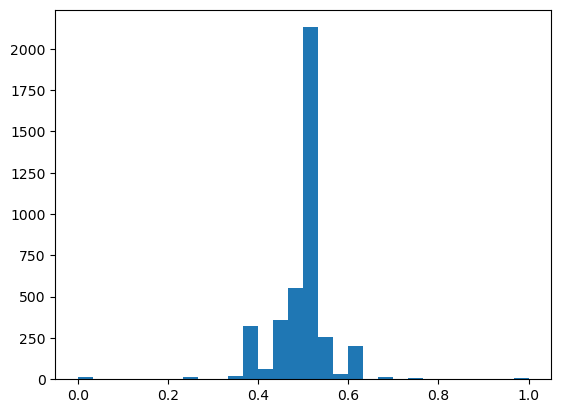

In [88]:
plt.hist(tally_pool_means['57 v 62'], bins = 30)

In [73]:
# CVR value: 1 / (2 - v_global)
sum([1 if c.pool == False else 0 for c in cvr_list]) # Vote by mail

1387622

In [74]:
sum([1 if c.pool == True else 0 for c in cvr_list]) # Precinct

216286

In [75]:
# Get number of CVRs in each precinct
precinct_dict = {}

for c in cvr_list:
    if c.pool == True:
        if c.tally_pool in precinct_dict:
            precinct_dict[c.tally_pool] += 1
        else:
            precinct_dict[c.tally_pool] = 1

In [76]:
sum(precinct_dict.values()) # Check that sums to precinct CVR count

216286

In [77]:
len(precinct_dict.keys())

4223

In [78]:
precinct_df = pd.DataFrame(list(precinct_dict.items()), columns=['Precinct ID', 'Total Votes'])

In [46]:
#precinct_df.to_csv("~/Downloads/precinct_df.csv")

,Precinct ID,Number
0,39-190,4
1,36-15,4
2,27-535,4
3,43-170,8
4,27-448,20
...,...,...
4218,27-157,4
4219,24-151,4
4220,27-415,8
4221,615-0,124
